# Customer Segmentation using K-Means Algorithm for Seasonal Profiles

The individual files should contain 3 months data of energy consumption in 15 minute interval

In [4]:
import polars as pl
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

logging.getLogger('matplotlib.font_manager').disabled = True

## load file containing outliers

In [2]:
outlier = pl.read_csv(r'C:\Users\pana\Desktop\DATA\ckw\outliers.csv')
outlier =outlier.to_numpy()
print("no of outliers are ",len(outlier))

no of outliers are  1657


## Select the season for clustering

In [3]:
# Function to extract numeric part from file name
season = "spring" 

def extract_numeric_part(file_path):
    match = re.search(rf'(\d+)_{season}_data\.csv', file_path)
    if match:
        return int(match.group(1))
    else:
        print(f"Warning: Filename {file_path} does not match pattern")
        return None

# Get the list of file paths
file_paths = glob.glob(rf'C:\Users\pana\Desktop\DATA\ckw\2021\{season}\*_{season}_data.csv')
file_paths = sorted(file_paths, key=extract_numeric_part)

file_paths = [file_paths[i] for i in range(len(file_paths)) if i not in outlier]
print("number of datasets remaining", len(file_paths))

number of datasets remaining 52203


In [6]:
#polars requires in this format
# yr,month,day,hour,min,sec

if season == "spring":
    timestamp_range = pl.datetime_range(datetime(2021,3,1), datetime(2021,5,31,22,45), "15m",eager=True)
elif season == "summer":
    timestamp_range = pl.datetime_range(datetime(2021,6,1), datetime(2021,8,31,23,45), "15m",eager=True)
elif season == "autumn":
    timestamp_range = pl.datetime_range(datetime(2021,8,31,23), datetime(2021,11,30,23,45), "15m",eager=True)
else:
    timestamp_range = pl.datetime_range(datetime(2021,12,1), datetime(2022,2,28,23,45), "15m",eager=True)

In [8]:
# Function for loading and preprocessing data into 3D numpy array format
def load_and_preprocess(file_paths, timestamp_range):
    # Number of timestamps per time series (e.g., 365 days * 96 intervals per day)
    n_timestamps = len(timestamp_range)
    
    # Initialize the 3D array with the right shape, but fill it incrementally
    n_time_series = 0
    data_3d = np.empty((0, n_timestamps, 1))  # Initially an empty array

    for idx,file_path in enumerate(file_paths):
        # Read the CSV file
        df = pl.read_csv(file_path)
        
        # Ensure that the data has the correct number of timestamps
        if len(df) == n_timestamps:
            # Extract values directly and reshape for 3D format (keeping memory usage low)
            values_array = df['value_kwh'].to_numpy().reshape((1, n_timestamps, 1))
            
            # Incrementally concatenate this data into the 3D array
            data_3d = np.concatenate([data_3d, values_array], axis=0)
            n_time_series += 1
        if idx%2000 ==0:
            print(f"{idx} out of {len(file_paths)} done")

    print(f"Shape of the 3D array: {data_3d.shape}")
    return data_3d

### K-means clustering

In [11]:
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans

train_data = load_and_preprocess(file_paths[:2000],timestamp_range)

n_clusters = 3  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

807.338 --> 598.067 --> 593.943 --> 592.821 --> 590.466 --> 587.454 --> 586.644 --> 586.374 --> 586.324 --> 586.193 --> 586.004 --> 585.868 --> 585.827 --> 585.796 --> 585.747 --> 585.698 --> 585.649 --> 585.604 --> 585.585 --> 585.558 --> 585.544 --> 585.504 --> 585.497 --> 585.497 --> 585.496 --> 585.496 --> 585.496 --> 


### Saving the cluster indices ( which household belongs to which cluster)

In [12]:
# Initialize an empty list to store individual DataFrames for each cluster
cluster_dataframes = []

for cluster_idx in range(n_clusters):
    # Get all indices in this cluster
    cluster_indices = np.where(clusters_train == cluster_idx)[0]
    
    # Create a Polars DataFrame for the current cluster's indices
    cluster_df = pl.DataFrame({
        "cluster": pl.Series([cluster_idx + 1] * len(cluster_indices)),
        "index": pl.Series(cluster_indices)
    })
    
    # Append this cluster DataFrame to the list
    cluster_dataframes.append(cluster_df)

# Concatenate all cluster DataFrames into one
cluster_indices_df = pl.concat(cluster_dataframes)

# Check if 13921 is in the 'index' column
number_to_check = 13921
exists = cluster_indices_df['index'].is_in([number_to_check]).any()

# Print the DataFrame to verify
print("\nCluster Indices DataFrame:")
print(cluster_indices_df.head())

cluster_indices_df.write_csv(rf'C:\Users\pana\Desktop\DATA\try\{season}_{n_clusters}_full_indices.csv')


Cluster Indices DataFrame:
shape: (5, 2)
┌─────────┬───────┐
│ cluster ┆ index │
│ ---     ┆ ---   │
│ i64     ┆ i64   │
╞═════════╪═══════╡
│ 1       ┆ 72    │
│ 1       ┆ 109   │
│ 1       ┆ 132   │
│ 1       ┆ 143   │
│ 1       ┆ 151   │
└─────────┴───────┘


## Plotting the seasonal cluster profiles


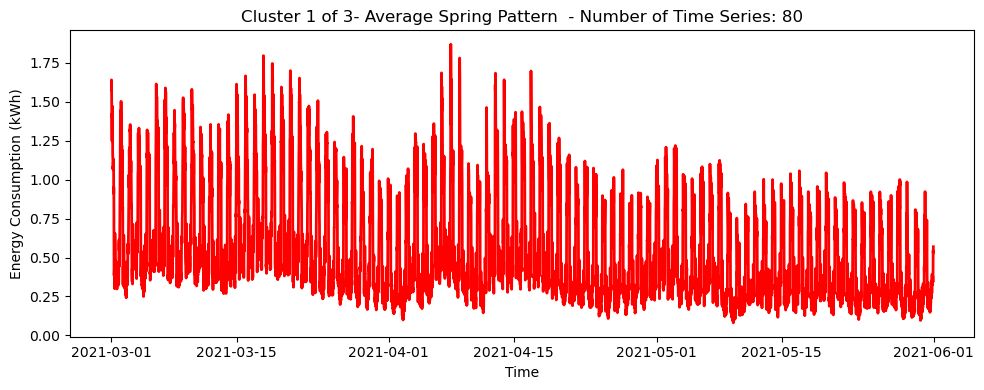

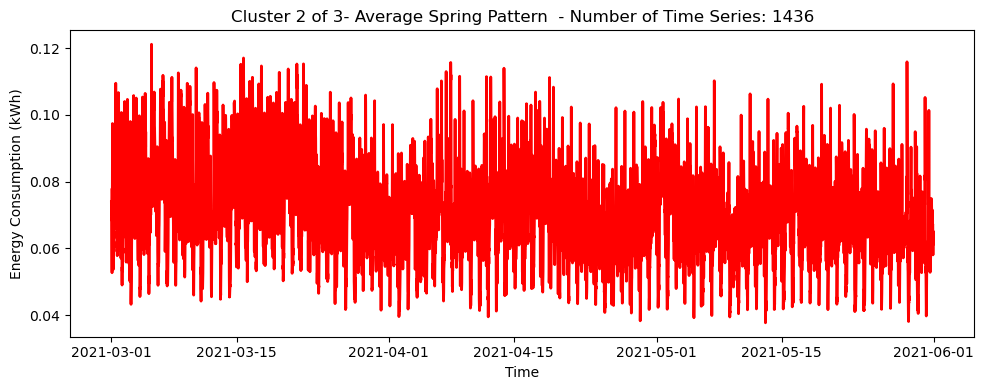

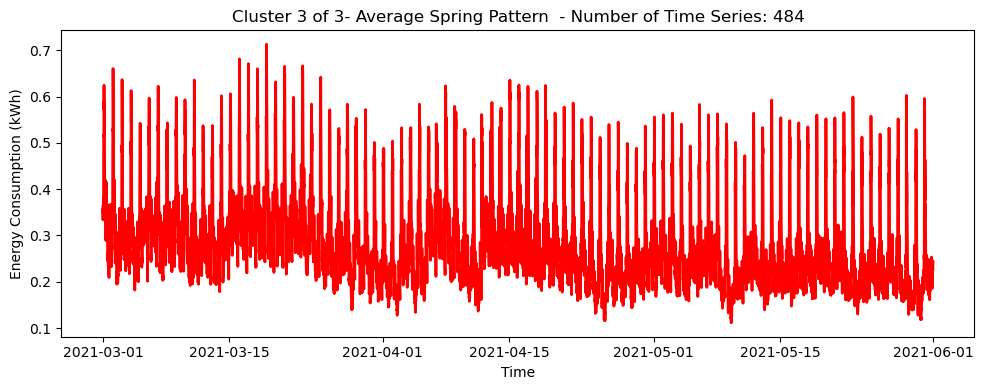

In [14]:
save = 0 #if you want to save the plots save = 1 and add path

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(10, 4))

    plt.plot(timestamp_range, mean_time_series.ravel(), linewidth =2, color='red' )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no} of {n_clusters}- Average Spring Pattern  - Number of Time Series: {len(cluster_indices)}")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.xticks()
    plt.tight_layout()
    #plt.legend()
    if save==1:
        plot_name=f'{cluster_idx}of4_{season}_avg.png'
        save_path=r'C:\Users\pana\Desktop\plots\without_outliers'
        plt.savefig(os.path.join(save_path,plot_name))
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

## Creating 3D plots of the seasonal clusters
Energy consumption with respect to intervals ( in a day) and Days ( 1 to number of days per season)

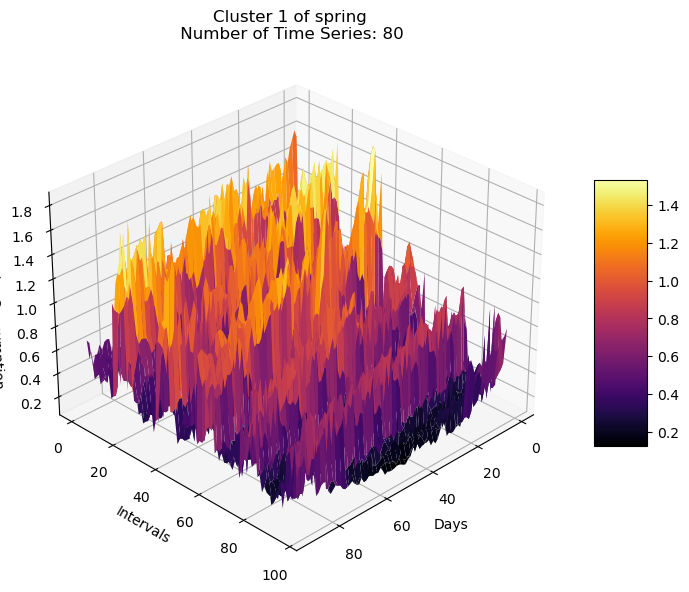

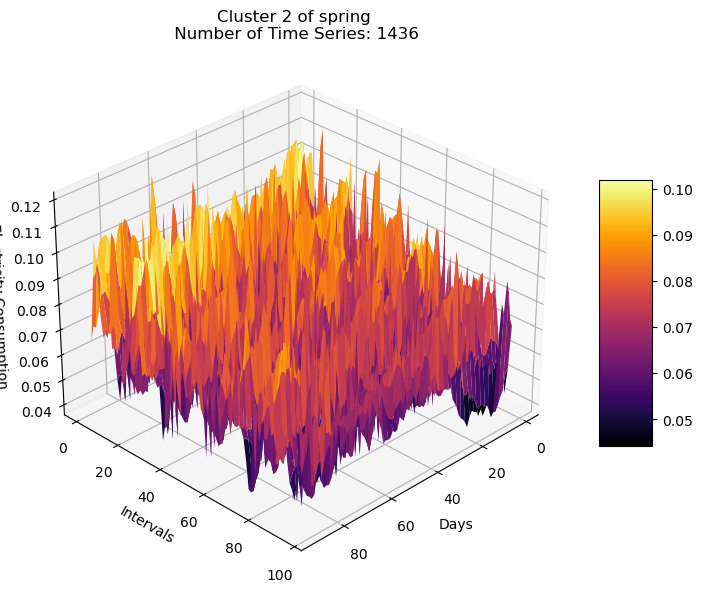

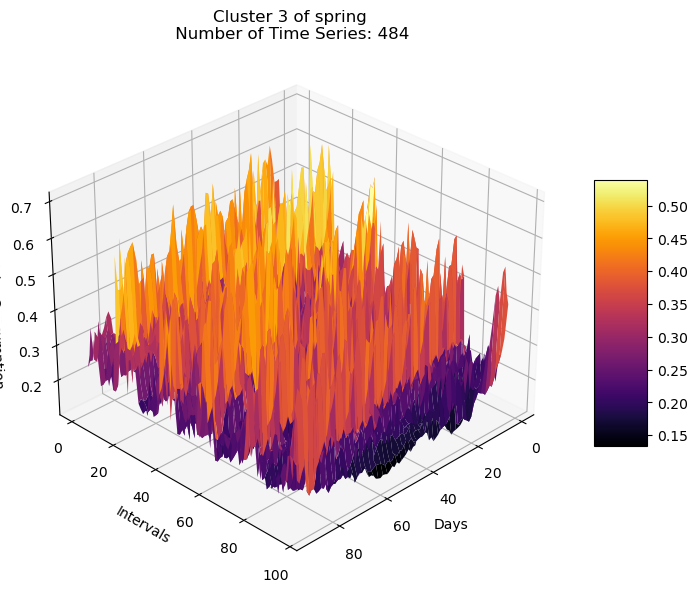

In [17]:
# Prepare data for 3D surface plot
num_days = (len(timestamp_range)-1) // 96  # Number of 
#num_days = 90
hours_per_day = 24
intervals_per_day = 96  # 15-minute intervals in a day
expected_size = num_days * intervals_per_day

days = np.arange(num_days) + 1  # Days start from 1
hours = np.arange(intervals_per_day) + 1  # Intervals start from 1

# Meshgrid for the surface plot
X, Y = np.meshgrid(days, hours)

# Loop through each cluster
for cluster_idx in range(n_clusters):
    # Create a new figure for each cluster
    fig = plt.figure(figsize=(8, 6))
    
    # Get time series data points in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]   
    
    # Calculate mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    if mean_time_series.size > expected_size:
        mean_time_series = mean_time_series[:expected_size]

    # Reshape the mean time series to match the meshgrid
    Z = mean_time_series.reshape((intervals_per_day, num_days))

    # Plotting the mean time series in 3D
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='inferno')

    # Customize plot labels and appearance
    ax.set_xlabel('Days')
    ax.set_ylabel('Intervals')
    #ax.set_yticks(range(1,96,4))
    ax.set_zlabel('Electricity Consumption')
    ax.set_title(f'Cluster {cluster_idx + 1} of {season}\n Number of Time Series: {len(cluster_indices)}' )
    ax.view_init(elev=30, azim=45) 

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)],
                   layout=go.Layout(
                xaxis=dict(title="X Axis Title"),
                yaxis=dict(title="Y Axis Title"),
                legend=dict(title="Legend Title"),
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple",
                    variant="small-caps",
                            )
                )
            )
 
    fig.update_layout(
        title=f"Cluster {cluster_idx + 1} of {season}\n Number of Time Series: {len(cluster_indices)}",
     
        )
    
    fig.write_html("file1.html") # to save as html file
    plt.tight_layout()
    
    # Optionally save the plot
    plt.savefig(f'clusters_3d_surface_plot_cluster_{cluster_idx + 1}.png') #to save as png

    # Show the plot
    plt.show()
